# Introduction to Clustering & Dimension Reduction

### ASI Data Science

#### Alexander Adam, Christiane Ahlheim

In [61]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import time
import imageio
from sklearn import cluster, datasets
from sklearn.cluster  import KMeans
from sklearn.datasets import load_digits            
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.cluster.vq import kmeans

from IPython.display  import Image as display_image
%matplotlib inline  

## 1. Image Segmentation with k-means

In this first section, we introduce the k-means algorithm - the simplest clustering algorithm and its implementation in sklearn. As a simple application, we then show how k-means clustering can be used to segment an image by colour. By grouping similar (r,g,b) values together we should be able to extract different parts of the picture. We begin by loading an image below:

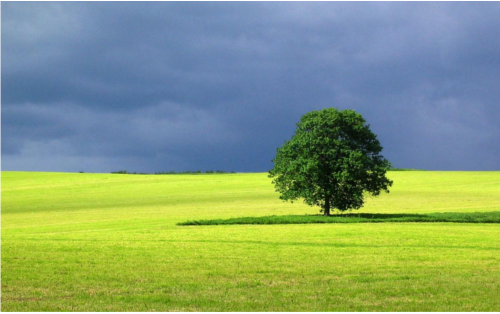

In [62]:
img = imageio.imread('./Landscape_small.png')
display_image(filename='./Landscape_small.png', width = 380, height = 380)

The image above consists of (314 x 500) pixels. Each entry in the img array above encodes the colour values for each pixel. There are four values - the three primary (rgb) colours as well as an alpha (opacity) value. The opacity value is not relevant here so we'll discard it. We need to reshape the img array above in other to get it into a form that is suitable for the sklearn machine learning algorithms. These generally take **two dimensional arrays** where **columns** are regarded as **features** and **rows** as **samples**. We'll therefore reshape img into a three column array (r,g,b) with as many rows as there are pixels

In [63]:
img = img[:, :, :3]

img_flat = sp.reshape(img, (img.shape[0]*img.shape[1],3)).astype(float)

print(img.shape, img_flat.shape)

(314, 500, 3) (157000, 3)


***K-means clustering in sklearn***  
Notice the similarity in syntax to the classifiers used in supervised learning. kmeans requires the number of clusters as input. The fit method calculates the centroids based on the input data, whilst the predict method assigns cluster membership to each point. Notice that once fitted, the predict method is able to take new data - so you can assign cluster membership to new points.

In [64]:
# K-means in sklearn.
clf = KMeans(n_clusters = 4, init='k-means++')
clf.fit(img_flat.astype(float)) 
indices= clf.predict(img_flat)

Think about what these indices actually mean before moving on. 

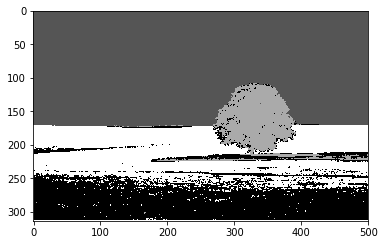

In [65]:
# Transform the image back into 2D and pass back to plt.imshow()
plt.imshow(sp.reshape(indices, (img.shape[0], img.shape[1])))

***Identifying the number of clusters***

The k-means algorithm requires the user to input the number of clusters. One issue is that in general we do not know a-priori what this value should be (unless we have application specific information). We should choose the number of clusters such that adding an additional cluster no longer gives 'better' modelling of the data. We can do this by plotting an objective function against the number of clusters and chosing the optimal value to be the point where the curve has a visible kink/elbow - indicating that adding additional clusters gives diminishing returns. A different approach is to optimise a quantity known as the average silhouette coefficient. This is something you can read about here:

http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

The code below shows how to generate such an 'elbow' plot using the average within-cluster sum of squares as the objective function.

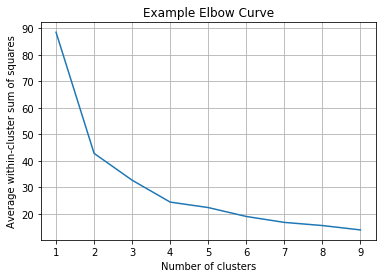

In [66]:
centroids=[[] for i in range(1,10)]
euclidean_distances=[0 for i in range(len(img_flat))]
cluster_averaged_distances=[0 for i in range(1,10)]

for K in range(1,10):
    clf = KMeans(n_clusters = K, init='k-means++')
    clf.fit(img_flat.astype(float))
    
    indices= clf.predict(img_flat)    
    centroids= clf.cluster_centers_ 
    
    for j in range(len(img_flat)):
        euclidean_distances[j]=0
        cluster=indices[j]
        for k in range(3):
            euclidean_distances[j]+=(img_flat[j][k] - centroids[cluster][k])**2
        euclidean_distances[j]=(euclidean_distances[j])**0.5

    cluster_averaged_distances[K-1]=np.mean(euclidean_distances)
               
plt.plot(range(1,10),cluster_averaged_distances)
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('Example Elbow Curve')  

As an aside, the loops in the calculation above make it very inefficient. There is a faster 'black box' implementation available in scipy (that uses a very slightly different objective function). The scipy method holds the results in a somewhat different format. It stores the coordinates of all centroids together with the average distance of points from their closest centroid (which is what we're after)

## 2. HDBSCAN

We have seen in this example that the k-means clustering algorithm performs reasonably well in our image example. However, in most scenarios it won't be as clear how many clusters you should expect, and you won't see an elbow in your plot to help you pick the right number of clusters.

Look at the following plot:
http://hdbscan.readthedocs.io/en/latest/_images/comparing_clustering_algorithms_6_0.png![image.png](attachment:image.png)

Here, it is hard to tell how many clustes to expect.

One of the most powerful clustering algorithms currently available is HDBSCAN: HDBSCAN is a density-based algorithm and performs single linkage clustering based on the density-space. 
HDBSCAN has two main advantages over k-means clustering:
* We don't need to provide the algorithm with a number of clusters a-priori
* HDBSCAN is conservative as it doesn't assign points to a cluster if there's no strong evidence to do so.

Furthermore, the cluster-solution found by HDBSCAN is stable over subsampling the data and different parameter choices and can be efficiently implemented. 


You can find more info on HDBSCAN here: https://github.com/lmcinnes/umap


In [7]:
# HDBSCAN is not part of sklearn, but we can easily install it and use it just as if it was part of it.
!pip install hdbscan

    100% |████████████████████████████████| 696kB 473kB/s ta 0:00:01
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [8]:
# For what follows it's useful to build a 2D scatter plot function that takes (data, labels) as arguments
import seaborn as sns 

def scatter(x, colors):
    count_colours = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", count_colours))

    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])

    return f, ax, sc

In [9]:
# Create dataset
n_samples = 1500
blobs = datasets.make_blobs(n_samples=n_samples,
                           random_state=42,
                           centers=[[2, 2],
                                    [-1, 1]],
                           cluster_std=[0.1, 0.5])
moons = datasets.make_moons(n_samples=n_samples, shuffle=True, noise=.05)

In [10]:
data = blobs[0] + moons[0] 
indices = np.zeros_like(len(data))

(<matplotlib.figure.Figure at 0x7fcd3c7e1438>,
 <matplotlib.collections.PathCollection at 0x7fcd2412d390>)

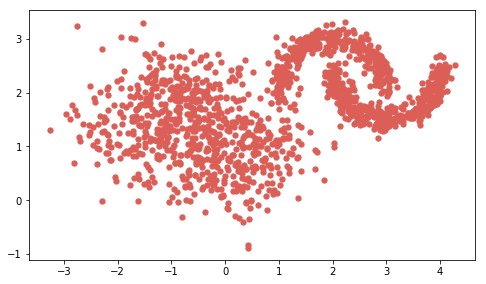

In [11]:
# let's have a look at our data!
scatter(data, indices)

### Exercise
Run k-means clustering and HDBSCAN clustering on the data. What results do you find and how do the two algorithms compare to each other? 

In [ ]:
## run k-means here (see above for code example)

## scatter takes the original data and the predicted cluster indices from k-means as input.
scatter(data, indices)

(<matplotlib.figure.Figure at 0x7fcd24123198>,
 <matplotlib.collections.PathCollection at 0x7fcd240727f0>)

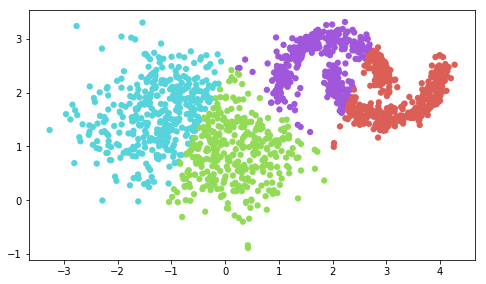

In [16]:
clf = KMeans(n_clusters = 4, init='k-means++')
clf.fit(data.astype(float)) 
indices= clf.predict(data)

scatter(data, indices)

(<matplotlib.figure.Figure at 0x7fcd882884e0>,
 <matplotlib.collections.PathCollection at 0x7fcd70f92828>)

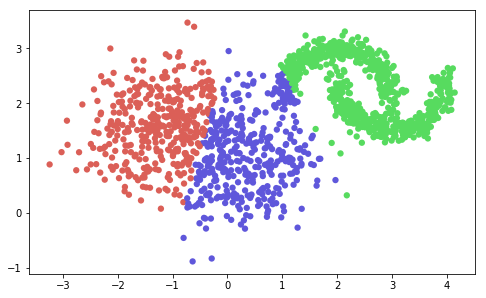

In [14]:
## solution, remove before course

clf = KMeans(n_clusters = 3, init='k-means++')
clf.fit(data) 
indices= clf.predict(data)
scatter(data, indices)

### Exercise: Can you detect the optimal number of clusters using an elbow plot? Are you satisfied with the result? 

--> This illustrates how k-means can fail, even if we could visually detect the correct number of clusters. 

(<matplotlib.figure.Figure at 0x7fcd24123940>,
 <matplotlib.collections.PathCollection at 0x7fcd06de2390>)

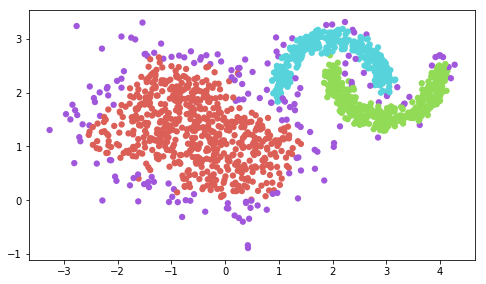

In [17]:
# Let's try the HDBSCAN algorighm
import hdbscan
clf = hdbscan.HDBSCAN(min_cluster_size=10)
indices = clf.fit_predict(data)
scatter(data, indices)

This results makes more sense (and doesn't need our input to detect the number of clusters). 
While k-means is an easy to understand algorithm, it has many downsides. HDBSCAN is able to detect structure in data and avoids common pitfalls.

### 3. Digits and Dimension Reduction

We now look at the sklearn digits dataset. These are images of hand-written digits. A classic problem (and now benchmmark for models) in machine learning is whether it is possible to train a classifier to distinguish between these different digits. This dataset is labelled but here we'll look at the extent to which purely unsupervised methods are able to segment this dataset. Each digit is an (8x8) collection of pixels and there are a total of 1797 samples in the dataset. This particular digits dataset can be regarded as a low dimensional analogue of the famous MNIST dataset. You can apply the exact same methods used here to that much higher dimensional case.

In [18]:
digits = load_digits()
digits.data.shape

X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])

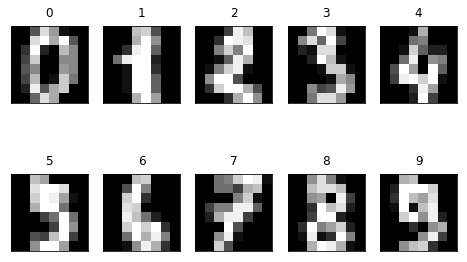

In [19]:
# Don't worry about the details of this plotting function. It's simply the show the handwritten digits to you.
nrows, ncols = 2, 5
plt.figure(figsize=(8,5))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(digits.images[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(digits.target[i])
plt.show()

#### Principal component analysis (PCA) in sklearn

The algorithm requires you to specify the number of principal components that you wish to retain. Note that PCA has both fit() and transform() methods. The former calculates the SVD of the input data and the necessary coordinate transformation to reduce the desired number of dimensions, whilst the latter actually applies the transformation. 

(<matplotlib.figure.Figure at 0x7fcd8a350518>,
 <matplotlib.collections.PathCollection at 0x7fcd6fe18f28>)

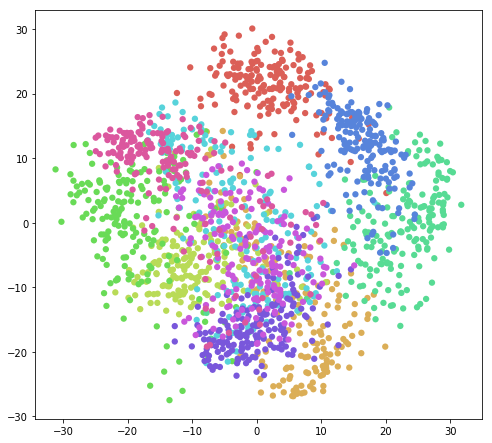

In [19]:
pca = PCA(n_components=2)                    
X_pca = pca.fit_transform(X)
scatter(X_pca, y)

As with clustering, it is important to have a mechanism to determine the correct number of principal components. In the case of PCA, the important quantity is the fraction of the total variance maintained as a function of the number of principal components retained. It is not uncommon to find in high dimensional dimension datasets that nearly all of the total variance can be retained whilst maintaining only a few principal components.

Text(0.5,0,'Number of PCA Components')

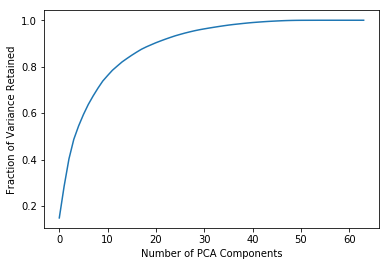

In [20]:
# re-run the PCA, this time keeping all components.
pca = PCA(n_components=64)                    
X_pca = pca.fit_transform(X)


# plot the explained variance
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.ylabel('Fraction of Variance Retained')
plt.xlabel('Number of PCA Components')

#### Exercise: Does PCA in 2D preserve the higher dimensional separation present in the digits dataset? How many components do you need to preserve this separation?

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html

PCA is a dimensional algorithm that projects data into a linear subspace. In contrast, there are other dimensional reduction algorithms that preserve *non-linear* structure. These algorithms can perform vastly better than PCA. The study of these falls under the topic of manifold learning. One particularly powerful example of manifold learning is an algorithm called t-SNE (t-distributed stochastic neighbour embedding). The details underpinning it are fairly involved and we won't talk about them here. You can read more about the algorithm here:

http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

One downside of the t-SNE algorithm is that it takes long to train. An new and extremely powerful alternative is UMAP (Uniform Manifold Approximation and Projection). As you'll see if you do the exercise below, it is very dramatically able to separate the digits dataset. You can read more about it here: https://github.com/lmcinnes/umap.

UMAP is not part of sklearn, so we have to install it first, but we can use it just as if it was part of sklearn.




In [21]:
!pip install umap-learn

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [22]:
from umap import UMAP

#### Exercise II: Does UMAP to 2D preserve the separation in the digits dataset?

(<matplotlib.figure.Figure at 0x7fcd02079400>,
 <matplotlib.collections.PathCollection at 0x7fccff994b70>)

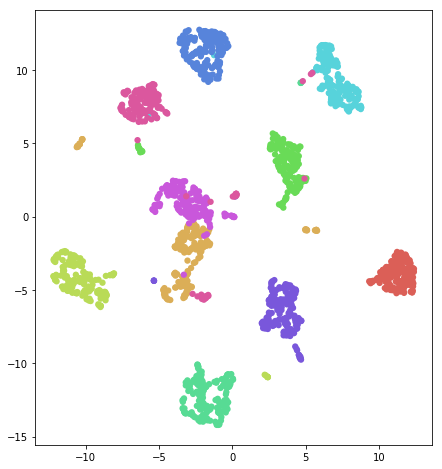

In [23]:
X_umap = UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation',
                      random_state=999).fit_transform(X)
scatter(X_umap, y) 

The difference to the results obtained by PCA are striking! We obtain 10 almost perfectly separated clusters. 
While this suggests that UMAP and other non-linear dimensionality reduction techniques may be superior to PCA and SVD, this might not always be true.
In particular when the structure of the data is truly linear, non-linear algorithms can be misleading and their results are generally harder to interpret (you can see some examples of how t-SNE results deviate from the ground-truth here: https://distill.pub/2016/misread-tsne/)

#### Exercise III: Can you tune the parameters of an HDBSCAN clusterer so that it labels the UMAP-reduced data optimally? 
HDBSCAN has one main parameter, which is the minimum cluster size (min_cluster_size). There are others, but those are harder to interpret.
In most cases, you won't be able to direclty assess how your clustering solution is doing. Here, we actually have access to the true labels (though we need to figure out first which cluster corresponds to which label).

(<matplotlib.figure.Figure at 0x7fccff994ef0>,
 <matplotlib.collections.PathCollection at 0x7fccffa20e10>)

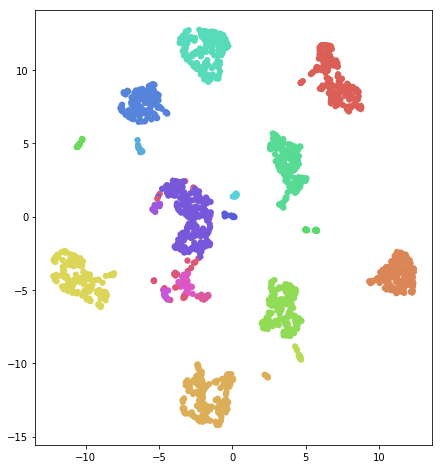

In [24]:
clf = hdbscan.HDBSCAN(min_cluster_size=10)
clf.fit(X_umap.astype(float)) 
indices= clf.fit_predict(X_umap)
scatter(X_umap, indices)

### 3. Other Clustering Algorithms

Clustering is an enormous subject and we have barely scratched the surface today. k-means (and its variations) are often a very good place to start, but in many practical situations it will be insufficient. This final section shows you some examples of where k-means fails to cluster correctly and invites you to investigate the behaviour of various other clustering algorithms in sklearn. We compare their ability to cluster four different datasets. The plotting function below will also give you some indication of the relative speeds of the different clustering algorithms.

In [27]:
# Generate four standard datasets for clustering. 

n_samples = 1500

noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

In [46]:
# A plotting function that will be used below. Do not worry about the details of this.

def PlotClustering(clustering_names, clustering_algorithms):
    
    plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))

    plot_num = 1

    datasets = [noisy_circles, noisy_moons, blobs, no_structure]
    for i_dataset, dataset in enumerate(datasets):
        X, y = dataset
        X = StandardScaler().fit_transform(X) # NOTE: Normalise your data before clustering

        for name, algorithm in zip(clustering_names, clustering_algorithms):
            # Predict cluster memberships
            plt.subplot(4, len(clustering_algorithms), plot_num)
            if i_dataset == 0:
                plt.title(name, size=18)

            if algorithm is None:
                plt.scatter(X[:, 0], X[:, 1], color='gray', s=10)
            else:
                t0 = time.time()
                algorithm.fit(X)
                t1 = time.time()
                if hasattr(algorithm, 'labels_'):
                    y_pred = algorithm.labels_.astype(np.int)
                else:
                    y_pred = algorithm.predict(X)

                # Plot
                plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

                if hasattr(algorithm, 'cluster_centers_'):
                    centers = algorithm.cluster_centers_
                    center_colors = colors[:len(centers)]
                    plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
            plt.xlim(-2, 2)
            plt.ylim(-2, 2)
            plt.xticks(())
            plt.yticks(())
            if algorithm is not None:
                plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                         transform=plt.gca().transAxes, size=15,
                         horizontalalignment='right')
            plot_num += 1

    plt.show()    
    

#### Exercise: Test different clustering algorithms on the four datasets below. You'll find they have different behaviours.

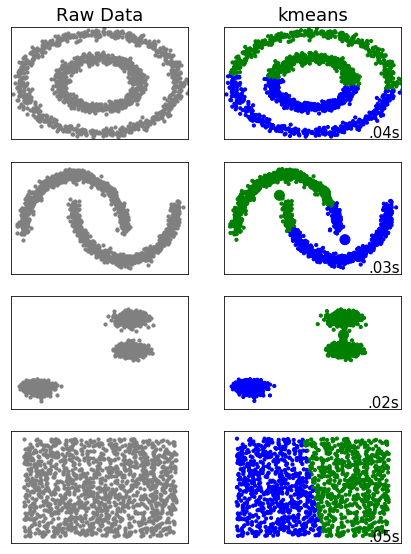

In [30]:
###### YOUR CODE GOES HERE ########
###################################

# FIND SOME CLUSTERING ALGORITHMS THAT BEST SEPARATE THIS DATA.
# You can see from what I've shown below that kmeans doesn't work very well here. 

###################################
###################################

from sklearn import cluster

kmeans = cluster.KMeans(n_clusters = 2)

names = ['Raw Data', 'kmeans']
algorithms = [None, kmeans] 

PlotClustering(names, algorithms)

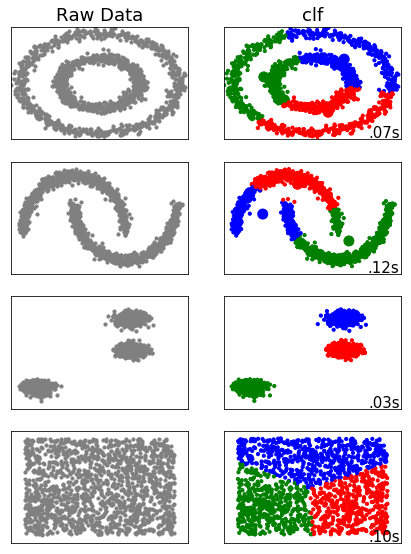

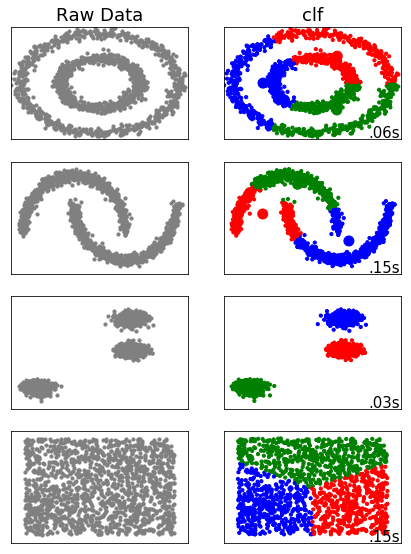

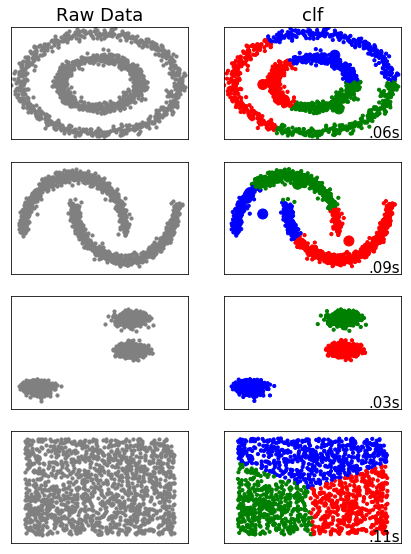

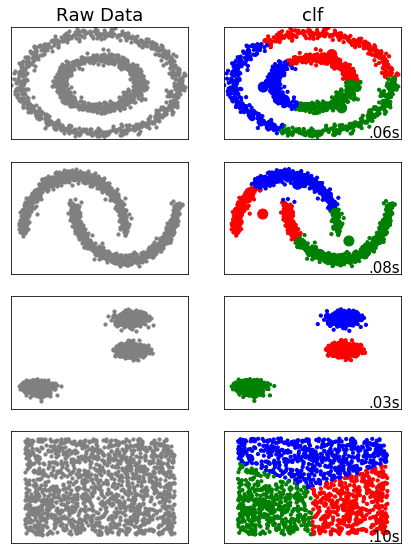

In [53]:
list_data = ["noisy_circles", "noisy_moons", "blobs", "no_structure"]
for i in range(0, len(list_data)):
    clf = KMeans(n_clusters = 3, init='k-means++')
    clf.fit(noisy_circles[0]) 
    indices= clf.predict(noisy_moons[0])
#     scatter(data, indices)
    names = ['Raw Data', 'clf']
    algorithms = [None, clf] 
    PlotClustering(names, algorithms)